# 05 - Gaussian Process Model for Nonlinear Effects

This notebook explores Gaussian Processes (GPs) as an alternative to splines for modeling
nonlinear age and mileage effects on Porsche 911 auction prices.

**Model structure:**
```
log_price ~ intercept
          + f_age(age)              # GP on age
          + f_mileage(log_mileage)  # GP on log-mileage
          + alpha_gen[generation]   # Random intercept
          + alpha_trim[trim_tier]   # Random intercept
          + alpha_trans[trans_type] # Random intercept
          + alpha_body[body_style]  # Random intercept
          + alpha_color[color]      # Random intercept
          + epsilon
```

**Key design choices:**
- **HSGP (Hilbert Space GP)**: Efficient approximation that scales linearly instead of O(n³)
- **Additive GPs**: Separate 1D GPs for age and mileage (simpler than 2D surface)
- **Raw PyMC**: Bambi doesn't support HSGP natively
- **Same random effects**: Matches spline model for fair comparison

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models.comparison import compare_models_loo
from price_analysis.models.hierarchical import check_diagnostics

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

print(f"PyMC version: {pm.__version__}")

PyMC version: 5.27.0


In [2]:
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

print(f"Model data: {len(df)} listings")
print(f"Age range: {df['age'].min():.0f} - {df['age'].max():.0f} years")
print(f"Log-mileage range: {df['log_mileage'].min():.2f} - {df['log_mileage'].max():.2f}")

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings
Age range: 0 - 26 years
Log-mileage range: 2.56 - 12.36


In [4]:
# Standardize continuous inputs for GP - critical for HSGP accuracy
AGE_MEAN, AGE_STD = df["age"].mean(), df["age"].std()
LOGM_MEAN, LOGM_STD = df["log_mileage"].mean(), df["log_mileage"].std()

df["age_std"] = (df["age"] - AGE_MEAN) / AGE_STD
df["log_mileage_std"] = (df["log_mileage"] - LOGM_MEAN) / LOGM_STD

# Validate input shapes for HSGP
assert df["age_std"].values.shape == (len(df),), f"Unexpected age_std shape: {df['age_std'].values.shape}"
assert df["log_mileage_std"].values.shape == (len(df),), f"Unexpected log_mileage_std shape: {df['log_mileage_std'].values.shape}"
assert not df["age_std"].isna().any(), "age_std contains NaN values"
assert not df["log_mileage_std"].isna().any(), "log_mileage_std contains NaN values"

print(f"Standardization parameters:")
print(f"  Age: mean={AGE_MEAN:.2f}, std={AGE_STD:.2f}")
print(f"  Log-mileage: mean={LOGM_MEAN:.2f}, std={LOGM_STD:.2f}")
print(f"\nStandardized ranges:")
print(f"  age_std: [{df['age_std'].min():.2f}, {df['age_std'].max():.2f}]")
print(f"  log_mileage_std: [{df['log_mileage_std'].min():.2f}, {df['log_mileage_std'].max():.2f}]")

Standardization parameters:
  Age: mean=13.59, std=8.13
  Log-mileage: mean=9.86, std=1.60

Standardized ranges:
  age_std: [-1.67, 1.53]
  log_mileage_std: [-4.55, 1.56]


In [5]:
# Create integer indices for categorical variables
gen_idx, gen_levels = pd.factorize(df["generation"], sort=True)
trim_idx, trim_levels = pd.factorize(df["trim_tier"], sort=True)
trans_idx, trans_levels = pd.factorize(df["trans_type"], sort=True)
body_idx, body_levels = pd.factorize(df["body_style"], sort=True)
color_idx, color_levels = pd.factorize(df["color_category"], sort=True)

print("Categorical levels:")
print(f"  Generation ({len(gen_levels)}): {list(gen_levels)}")
print(f"  Trim tier ({len(trim_levels)}): {list(trim_levels)}")
print(f"  Trans type ({len(trans_levels)}): {list(trans_levels)}")
print(f"  Body style ({len(body_levels)}): {list(body_levels)}")
print(f"  Color category ({len(color_levels)}): {list(color_levels)}")

Categorical levels:
  Generation (8): ['991.1', '991.2', '992.1', '992.2', '996.1', '996.2', '997.1', '997.2']
  Trim tier (6): ['base', 'gt', 'gts', 'rs', 'sport', 'turbo']
  Trans type (3): ['auto', 'manual', 'pdk']
  Body style (3): ['cabriolet', 'coupe', 'targa']
  Color category (4): ['PTS', 'special', 'standard', 'unknown']


## GP Background: Why HSGP?

### The Problem with Standard GPs

Standard Gaussian Process regression has O(n³) computational complexity due to matrix inversion.
With n=1360 observations, this becomes slow and memory-intensive.

### HSGP: Hilbert Space Approximation

HSGP (Solin & Särkkä, 2020) approximates the GP using a truncated basis expansion:

$$f(x) \approx \sum_{j=1}^{m} \phi_j(x) \cdot \beta_j$$

where:
- $\phi_j(x)$ are pre-computed basis functions (depend only on input domain, not kernel params)
- $\beta_j$ are coefficients with priors derived from the kernel's spectral density
- $m$ controls approximation accuracy (more = better but slower)

**Advantages:**
- O(nm + m) complexity instead of O(n³)
- Predictions via `pm.set_data()` without expensive GP conditioning
- Works well for 1-2D inputs with stationary kernels

**Limitations:**
- Approximation quality depends on lengthscale relative to domain size
- Less accurate for rapidly varying functions (short lengthscales)
- Requires bounded domain

### Key Parameters

| Parameter | Our choice | Rationale |
|-----------|------------|------------|
| `m` | 20 | Moderate accuracy, reasonable speed |
| `c` | 1.5 | Extends domain 50% beyond data range |
| Kernel | Matern52 | Allows local variation (less smooth than ExpQuad) |

### Why Additive (Not 2D) GP?

We use separate 1D GPs for age and log-mileage instead of a single 2D GP:

1. **Simpler**: Each GP has its own lengthscale, easier to interpret
2. **More robust**: 2D HSGP requires m² basis functions
3. **Sufficient**: If residuals show age×mileage interaction, we can revisit

## Build GP Model

In [6]:
# HSGP configuration
M_BASIS = 20  # Number of basis functions per GP
C_FACTOR = 1.5  # Domain extension factor

# Coordinates for labeled dimensions
coords = {
    "generation": gen_levels,
    "trim_tier": trim_levels,
    "trans_type": trans_levels,
    "body_style": body_levels,
    "color_category": color_levels,
    "obs": np.arange(len(df)),
}

In [7]:
with pm.Model(coords=coords) as gp_model:
    # === Data containers ===
    age_data = pm.Data("age_std", df["age_std"].values)
    mileage_data = pm.Data("log_mileage_std", df["log_mileage_std"].values)
    y_data = pm.Data("log_price", df["log_price"].values)
    
    gen_data = pm.Data("gen_idx", gen_idx)
    trim_data = pm.Data("trim_idx", trim_idx)
    trans_data = pm.Data("trans_idx", trans_idx)
    body_data = pm.Data("body_idx", body_idx)
    color_data = pm.Data("color_idx", color_idx)
    
    # === Intercept ===
    intercept = pm.Normal("intercept", mu=df["log_price"].mean(), sigma=2)
    
    # === GP for age ===
    # InverseGamma(3, 2) has mode ~0.5, allows non-linearity for classic car appreciation
    ls_age = pm.InverseGamma("ls_age", alpha=3, beta=2)
    eta_age = pm.HalfNormal("eta_age", sigma=0.3)
    
    # Matern52 kernel
    cov_age = eta_age**2 * pm.gp.cov.Matern52(input_dim=1, ls=ls_age)
    
    # HSGP approximation
    gp_age = pm.gp.HSGP(m=[M_BASIS], c=C_FACTOR, cov_func=cov_age)
    f_age = gp_age.prior("f_age", X=age_data[:, None])
    
    # === GP for log-mileage ===
    # InverseGamma(3, 3) has mode ~0.75, encodes near-monotonic mileage effect
    ls_mileage = pm.InverseGamma("ls_mileage", alpha=3, beta=3)
    eta_mileage = pm.HalfNormal("eta_mileage", sigma=0.3)
    
    cov_mileage = eta_mileage**2 * pm.gp.cov.Matern52(input_dim=1, ls=ls_mileage)
    
    gp_mileage = pm.gp.HSGP(m=[M_BASIS], c=C_FACTOR, cov_func=cov_mileage)
    f_mileage = gp_mileage.prior("f_mileage", X=mileage_data[:, None])
    
    # === Random intercepts (non-centered parameterization) ===
    # Generation
    sigma_gen = pm.HalfNormal("sigma_gen", sigma=0.5)
    alpha_gen_offset = pm.Normal("alpha_gen_offset", mu=0, sigma=1, dims="generation")
    alpha_gen = pm.Deterministic("alpha_gen", alpha_gen_offset * sigma_gen, dims="generation")
    
    # Trim tier
    sigma_trim = pm.HalfNormal("sigma_trim", sigma=0.7)
    alpha_trim_offset = pm.Normal("alpha_trim_offset", mu=0, sigma=1, dims="trim_tier")
    alpha_trim = pm.Deterministic("alpha_trim", alpha_trim_offset * sigma_trim, dims="trim_tier")
    
    # Transmission type
    sigma_trans = pm.HalfNormal("sigma_trans", sigma=0.3)
    alpha_trans_offset = pm.Normal("alpha_trans_offset", mu=0, sigma=1, dims="trans_type")
    alpha_trans = pm.Deterministic("alpha_trans", alpha_trans_offset * sigma_trans, dims="trans_type")
    
    # Body style
    sigma_body = pm.HalfNormal("sigma_body", sigma=0.3)
    alpha_body_offset = pm.Normal("alpha_body_offset", mu=0, sigma=1, dims="body_style")
    alpha_body = pm.Deterministic("alpha_body", alpha_body_offset * sigma_body, dims="body_style")
    
    # Color category
    sigma_color = pm.HalfNormal("sigma_color", sigma=0.3)
    alpha_color_offset = pm.Normal("alpha_color_offset", mu=0, sigma=1, dims="color_category")
    alpha_color = pm.Deterministic("alpha_color", alpha_color_offset * sigma_color, dims="color_category")
    
    # === Mean function ===
    mu = (
        intercept
        + f_age
        + f_mileage
        + alpha_gen[gen_data]
        + alpha_trim[trim_data]
        + alpha_trans[trans_data]
        + alpha_body[body_data]
        + alpha_color[color_data]
    )
    
    # === Observation noise (matches spline model's Bambi default) ===
    sigma_obs = pm.HalfStudentT("sigma_obs", nu=4, sigma=0.8229)
    
    # === Likelihood ===
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_obs, observed=y_data, dims="obs")

print(gp_model)

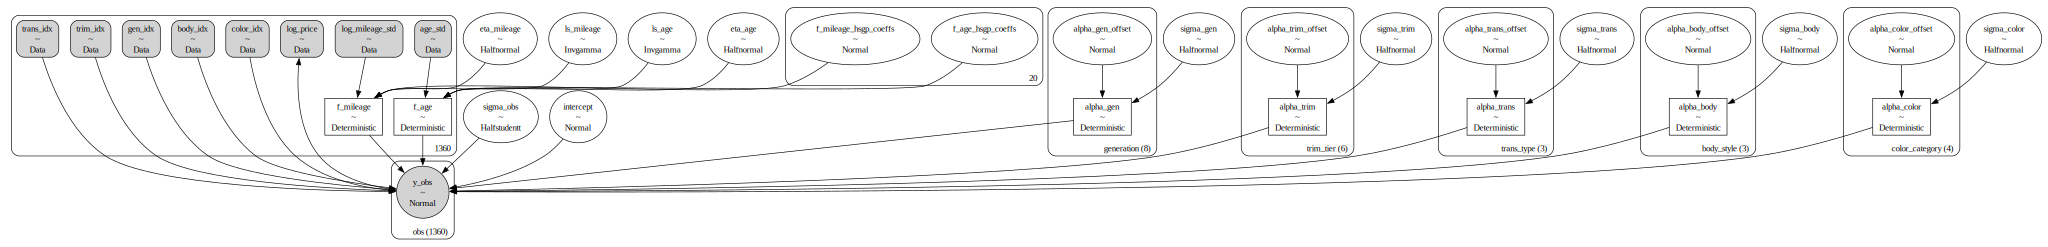

In [8]:
# Visualize model graph
pm.model_to_graphviz(gp_model)

## Prior Predictive Check

Before fitting, verify that our priors produce reasonable function shapes.

In [9]:
with gp_model:
    prior_pred = pm.sample_prior_predictive(samples=100, random_seed=42)

Sampling: [alpha_body_offset, alpha_color_offset, alpha_gen_offset, alpha_trans_offset, alpha_trim_offset, eta_age, eta_mileage, f_age_hsgp_coeffs, f_mileage_hsgp_coeffs, intercept, ls_age, ls_mileage, sigma_body, sigma_color, sigma_gen, sigma_obs, sigma_trans, sigma_trim, y_obs]
INFO:pymc.sampling.forward:Sampling: [alpha_body_offset, alpha_color_offset, alpha_gen_offset, alpha_trans_offset, alpha_trim_offset, eta_age, eta_mileage, f_age_hsgp_coeffs, f_mileage_hsgp_coeffs, intercept, ls_age, ls_mileage, sigma_body, sigma_color, sigma_gen, sigma_obs, sigma_trans, sigma_trim, y_obs]


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/2074927238.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


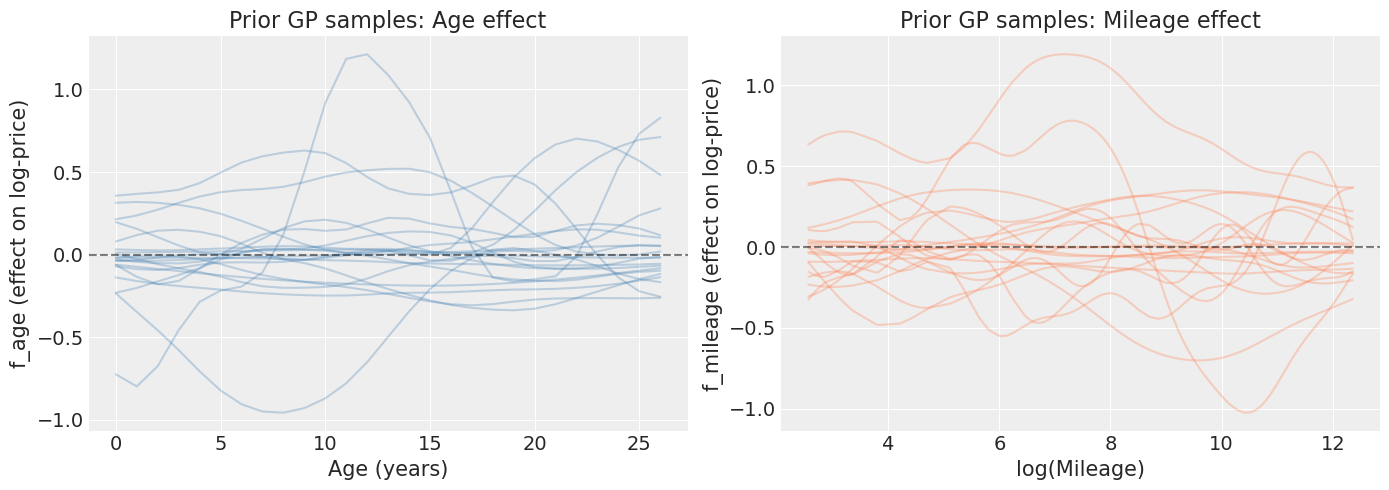

In [10]:
# Plot prior GP function draws
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort for plotting
age_order = np.argsort(df["age_std"].values)
mileage_order = np.argsort(df["log_mileage_std"].values)

# Age GP prior samples
ax = axes[0]
f_age_prior = prior_pred.prior["f_age"].values[0]  # (samples, obs)
for i in range(min(20, f_age_prior.shape[0])):
    ax.plot(df["age"].values[age_order], f_age_prior[i, age_order], alpha=0.3, color="steelblue")
ax.axhline(0, color="black", linestyle="--", alpha=0.5)
ax.set_xlabel("Age (years)")
ax.set_ylabel("f_age (effect on log-price)")
ax.set_title("Prior GP samples: Age effect")

# Mileage GP prior samples
ax = axes[1]
f_mileage_prior = prior_pred.prior["f_mileage"].values[0]
for i in range(min(20, f_mileage_prior.shape[0])):
    ax.plot(df["log_mileage"].values[mileage_order], f_mileage_prior[i, mileage_order], 
            alpha=0.3, color="coral")
ax.axhline(0, color="black", linestyle="--", alpha=0.5)
ax.set_xlabel("log(Mileage)")
ax.set_ylabel("f_mileage (effect on log-price)")
ax.set_title("Prior GP samples: Mileage effect")

plt.tight_layout()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/1599390582.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Prior predictive log-price range: [0.7, 22.2]
Data log-price range: [9.28, 13.53]


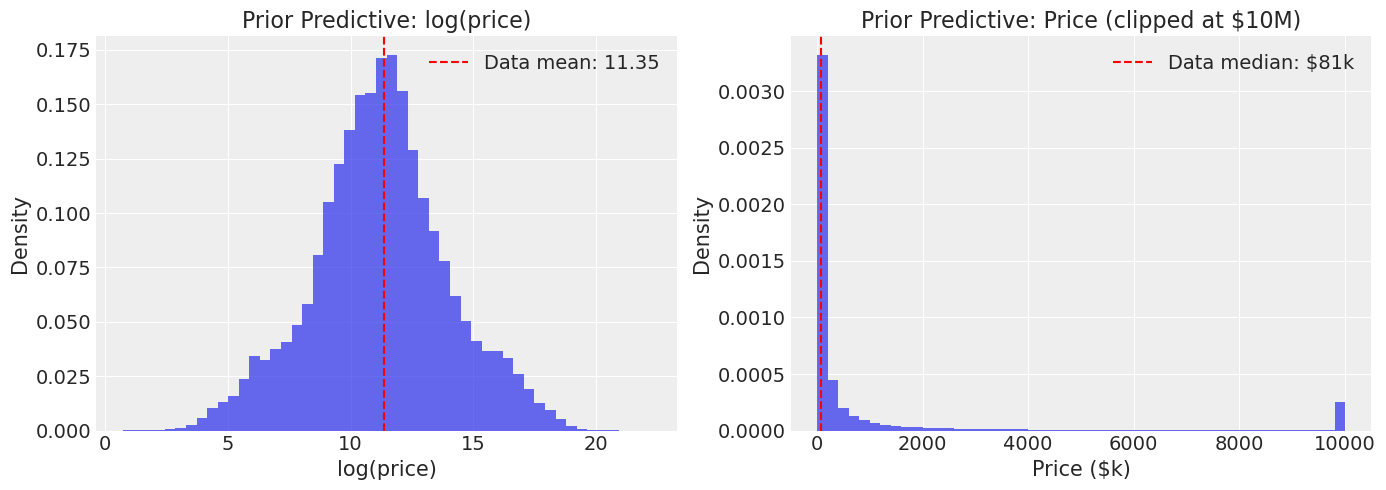

In [11]:
# Prior predictive distribution of prices
y_prior = prior_pred.prior_predictive["y_obs"].values.flatten()
price_prior = np.exp(y_prior)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(y_prior, bins=50, alpha=0.7, density=True)
ax.axvline(df["log_price"].mean(), color="red", linestyle="--", label=f"Data mean: {df['log_price'].mean():.2f}")
ax.set_xlabel("log(price)")
ax.set_ylabel("Density")
ax.set_title("Prior Predictive: log(price)")
ax.legend()

ax = axes[1]
# Clip extreme values for visualization
price_clipped = np.clip(price_prior, 0, 1e7)
ax.hist(price_clipped / 1000, bins=50, alpha=0.7, density=True)
ax.axvline(np.exp(df["log_price"]).median() / 1000, color="red", linestyle="--", 
           label=f"Data median: ${np.exp(df['log_price']).median()/1000:.0f}k")
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("Prior Predictive: Price (clipped at $10M)")
ax.legend()

plt.tight_layout()

print(f"Prior predictive log-price range: [{y_prior.min():.1f}, {y_prior.max():.1f}]")
print(f"Data log-price range: [{df['log_price'].min():.2f}, {df['log_price'].max():.2f}]")

## Fit GP Model

In [12]:
%%time
with gp_model:
    idata_gp = pm.sample(
        draws=1000,
        tune=1000,
        chains=8,
        cores=8,
        target_accept=0.95,
        random_seed=42,
        idata_kwargs={"log_likelihood": True},
    )

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [intercept, ls_age, eta_age, f_age_hsgp_coeffs, ls_mileage, eta_mileage, f_mileage_hsgp_coeffs, sigma_gen, alpha_gen_offset, sigma_trim, alpha_trim_offset, sigma_trans, alpha_trans_offset, sigma_body, alpha_body_offset, sigma_color, alpha_color_offset, sigma_obs]
INFO:pymc.sampling.mcmc:NUTS: [intercept, ls_age, eta_age, f_age_hsgp_coeffs, ls_mileage, eta_mileage, f_mileage_hsgp_coeffs, sigma_gen, alpha_gen_offset, sigma_trim, alpha_trim_offset, sigma_trans, alpha_trans_offset, sigma_body, alpha_body_offset, sigma_color, alpha_color_offset, sigma_obs]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 517 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 517 seconds.


CPU times: user 33.4 s, sys: 2.04 s, total: 35.4 s
Wall time: 8min 47s


In [13]:
# Check diagnostics
diagnostics = check_diagnostics(idata_gp)
print(f"Converged: {diagnostics['converged']}")
print(f"Divergences: {diagnostics['n_divergences']}")
print(f"Max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"Min ESS (bulk): {diagnostics['ess_bulk_min']:.0f}")
if diagnostics["issues"]:
    print(f"Issues: {diagnostics['issues']}")

Converged: True
Divergences: 0
Max R-hat: 1.000
Min ESS (bulk): 2075


In [14]:
# Summary of key parameters
var_names = ["intercept", "ls_age", "ls_mileage", "eta_age", "eta_mileage", 
             "sigma_gen", "sigma_trim", "sigma_trans", "sigma_body", "sigma_color", "sigma_obs"]
summary = az.summary(idata_gp, var_names=var_names)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,11.620,0.442,10.812,12.478,0.007,0.005,3486.0,4557.0,1.0
ls_age,0.915,0.344,0.322,1.523,0.007,0.004,2075.0,4121.0,1.0
ls_mileage,1.400,0.320,0.810,1.985,0.005,0.004,3642.0,4808.0,1.0
eta_age,0.325,0.126,0.127,0.566,0.002,0.002,4497.0,5110.0,1.0
eta_mileage,0.437,0.123,0.231,0.662,0.002,0.001,4169.0,4704.0,1.0
sigma_gen,0.149,0.086,0.028,0.308,0.002,0.002,2239.0,3346.0,1.0
sigma_trim,0.499,0.184,0.236,0.837,0.003,0.003,3496.0,5237.0,1.0
sigma_trans,0.192,0.112,0.052,0.402,0.001,0.002,5310.0,5201.0,1.0
sigma_body,0.215,0.115,0.063,0.427,0.001,0.002,5230.0,5533.0,1.0
sigma_color,0.125,0.074,0.032,0.260,0.001,0.001,3240.0,4396.0,1.0


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/2517340417.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


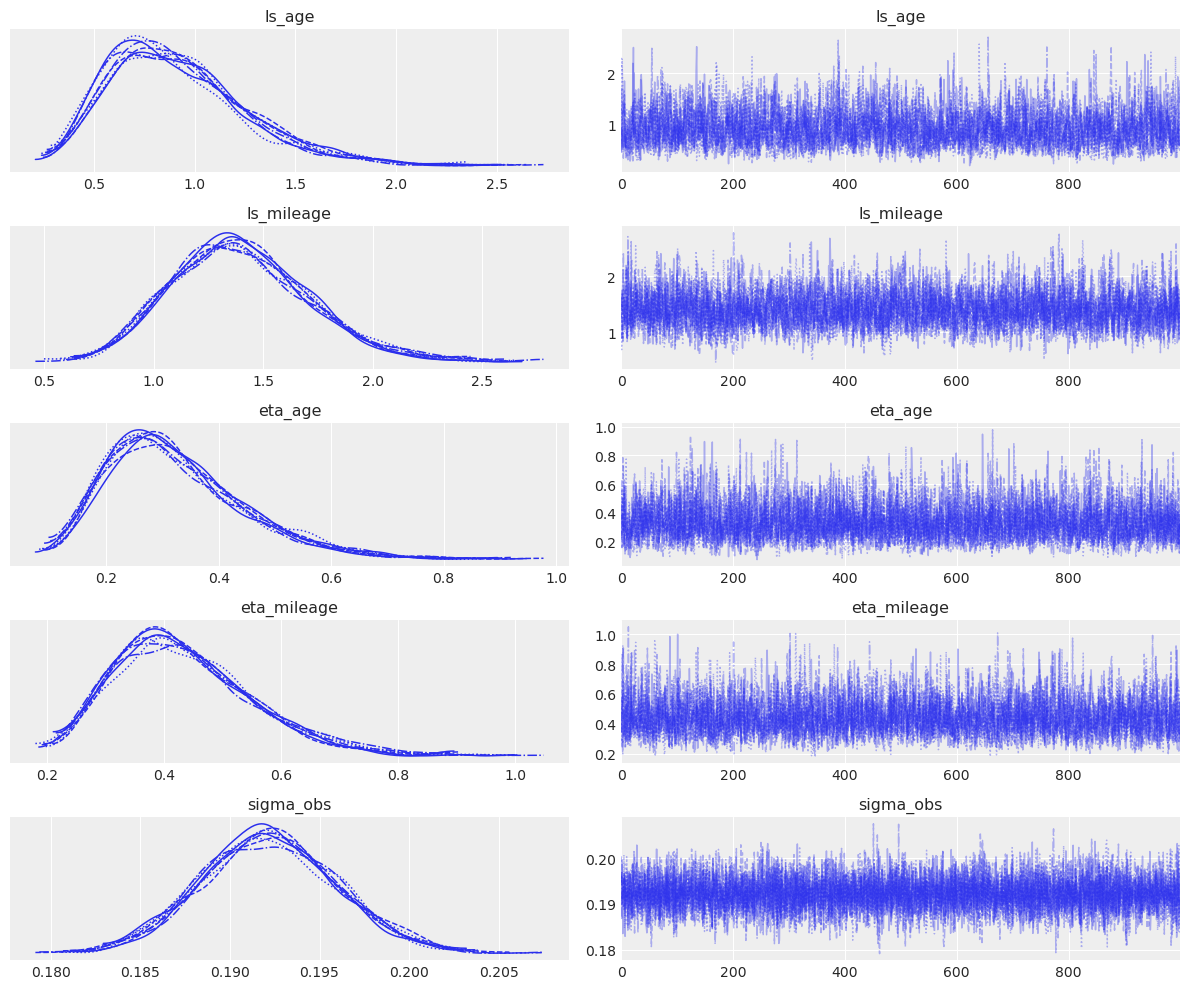

In [15]:
# Trace plots for GP hyperparameters
az.plot_trace(idata_gp, var_names=["ls_age", "ls_mileage", "eta_age", "eta_mileage", "sigma_obs"])
plt.tight_layout()

## Visualize GP Effects

Plot the learned nonlinear relationships between age/mileage and log-price.

In [16]:
def plot_gp_effect(
    idata: az.InferenceData,
    gp_var: str,
    x_data: np.ndarray,
    x_label: str,
    ax: plt.Axes,
    ci: float = 0.9,
) -> None:
    """Plot GP posterior mean and credible interval."""
    # Get posterior samples
    f_samples = idata.posterior[gp_var].values
    f_samples = f_samples.reshape(-1, len(x_data))  # (chains*draws, n_obs)
    
    # Sort by x for plotting
    order = np.argsort(x_data)
    x_sorted = x_data[order]
    f_sorted = f_samples[:, order]
    
    # Compute statistics
    f_mean = f_sorted.mean(axis=0)
    alpha = (1 - ci) / 2
    f_lower = np.percentile(f_sorted, alpha * 100, axis=0)
    f_upper = np.percentile(f_sorted, (1 - alpha) * 100, axis=0)
    
    # Plot
    ax.plot(x_sorted, f_mean, "b-", linewidth=2, label="Posterior mean")
    ax.fill_between(x_sorted, f_lower, f_upper, alpha=0.3, color="blue", 
                    label=f"{int(ci*100)}% CI")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.5)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Effect on log(price)")
    ax.legend()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/2117381442.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


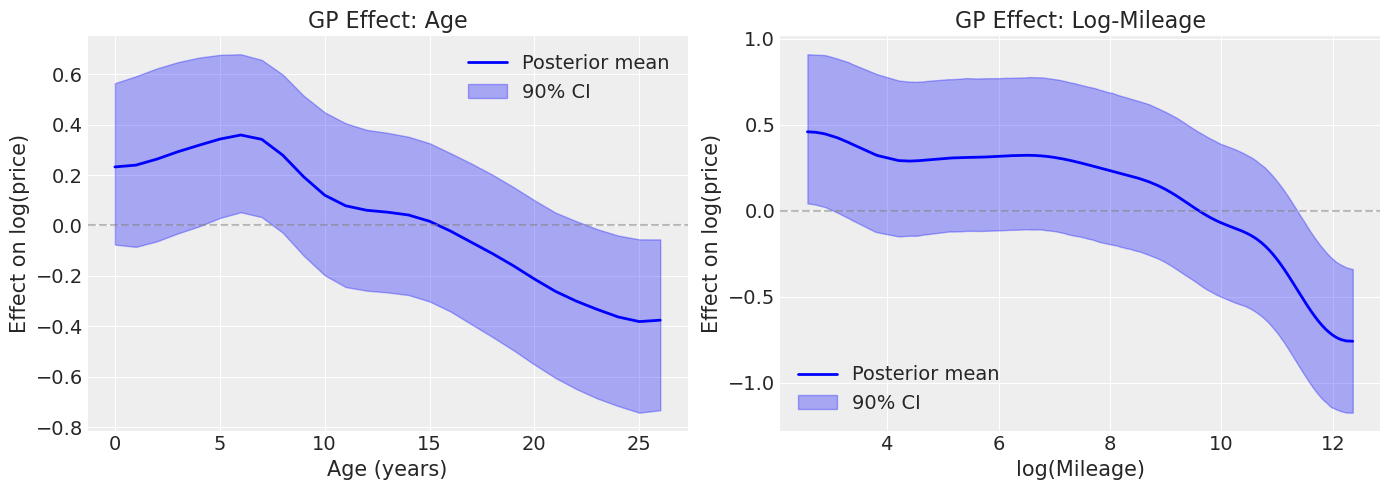

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age effect
plot_gp_effect(idata_gp, "f_age", df["age"].values, "Age (years)", axes[0])
axes[0].set_title("GP Effect: Age")

# Mileage effect
plot_gp_effect(idata_gp, "f_mileage", df["log_mileage"].values, "log(Mileage)", axes[1])
axes[1].set_title("GP Effect: Log-Mileage")

plt.tight_layout()

In [18]:
# Interpretation: convert GP effects to percentage price changes
f_age_samples = idata_gp.posterior["f_age"].values.reshape(-1, len(df))
f_mileage_samples = idata_gp.posterior["f_mileage"].values.reshape(-1, len(df))

# Effect range (max - min effect)
age_effect_range = f_age_samples.mean(axis=0).max() - f_age_samples.mean(axis=0).min()
mileage_effect_range = f_mileage_samples.mean(axis=0).max() - f_mileage_samples.mean(axis=0).min()

print("GP effect ranges (on log-price scale):")
print(f"  Age: {age_effect_range:.3f} = {(np.exp(age_effect_range) - 1) * 100:.1f}% price difference")
print(f"  Mileage: {mileage_effect_range:.3f} = {(np.exp(mileage_effect_range) - 1) * 100:.1f}% price difference")

GP effect ranges (on log-price scale):
  Age: 0.740 = 109.7% price difference
  Mileage: 1.218 = 238.2% price difference


## Random Effects Analysis

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/3671531400.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


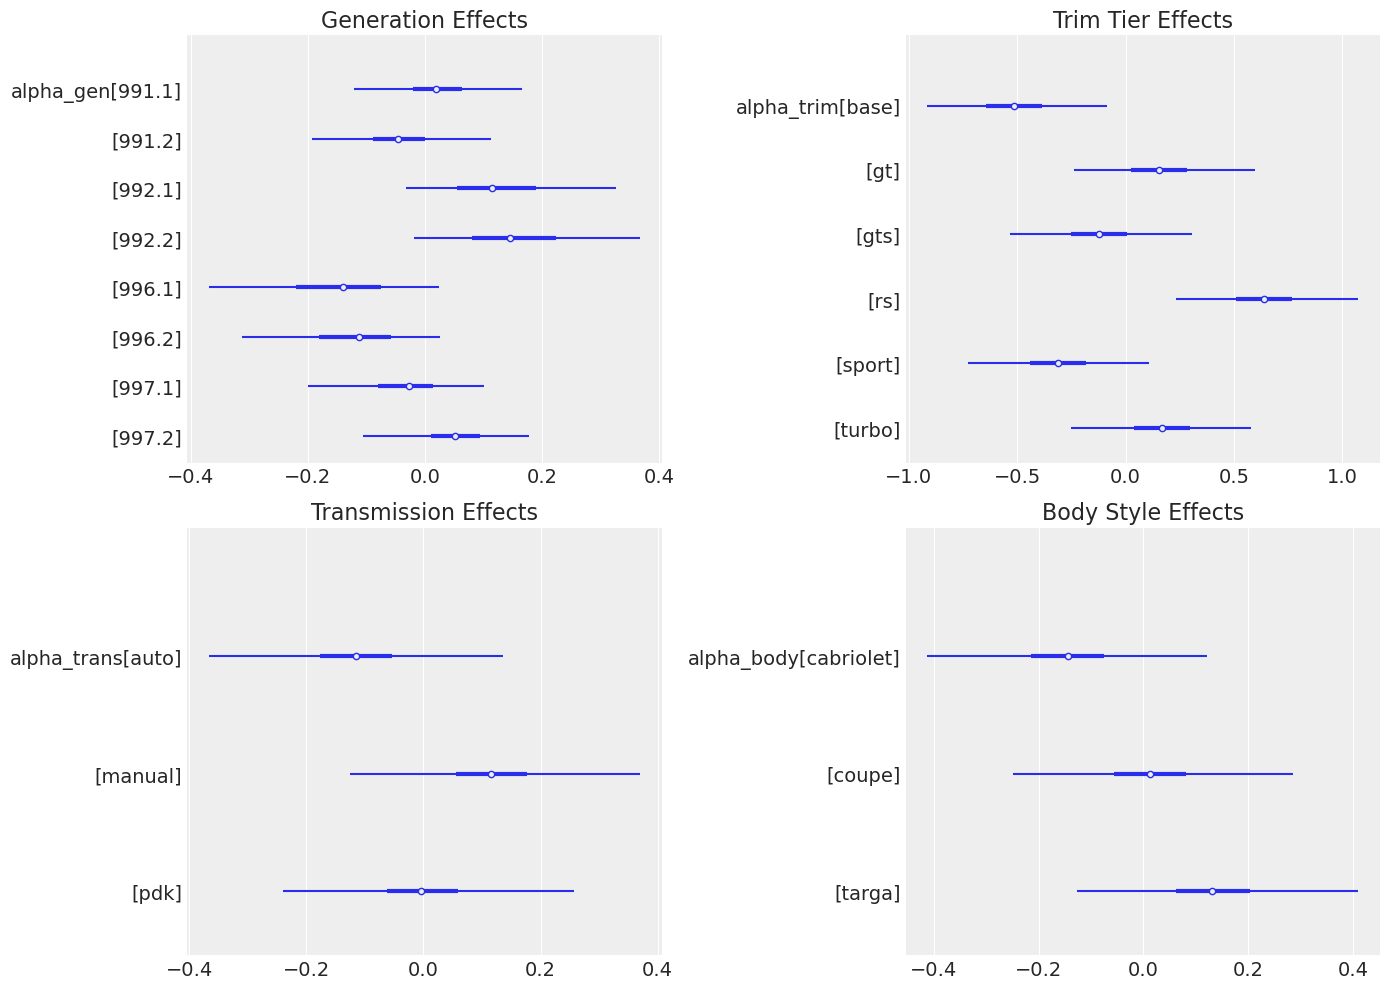

In [19]:
# Forest plots for random intercepts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

az.plot_forest(idata_gp, var_names=["alpha_gen"], combined=True, ax=axes[0, 0])
axes[0, 0].set_title("Generation Effects")

az.plot_forest(idata_gp, var_names=["alpha_trim"], combined=True, ax=axes[0, 1])
axes[0, 1].set_title("Trim Tier Effects")

az.plot_forest(idata_gp, var_names=["alpha_trans"], combined=True, ax=axes[1, 0])
axes[1, 0].set_title("Transmission Effects")

az.plot_forest(idata_gp, var_names=["alpha_body"], combined=True, ax=axes[1, 1])
axes[1, 1].set_title("Body Style Effects")

plt.tight_layout()

Text(0.5, 1.0, 'Color Category Effects')

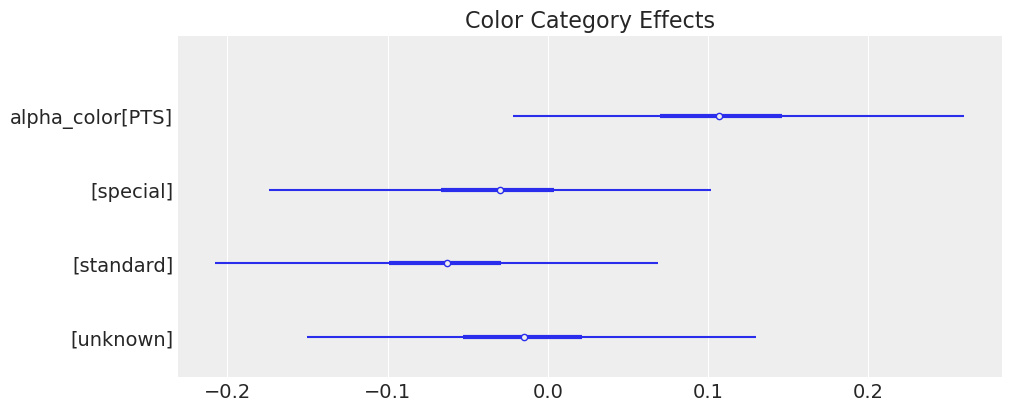

In [20]:
# Color category effects
az.plot_forest(idata_gp, var_names=["alpha_color"], combined=True, figsize=(10, 4))
plt.title("Color Category Effects")

In [21]:
# Dollar premiums for random effects
REFERENCE_PRICE = 80000

def compute_premium(idata, var_name, level_names, baseline_idx=0):
    """Compute dollar premiums relative to baseline level."""
    samples = idata.posterior[var_name].values
    samples = samples.reshape(-1, len(level_names))
    
    baseline = samples[:, baseline_idx]
    premiums = {}
    for i, name in enumerate(level_names):
        if i == baseline_idx:
            continue
        diff = samples[:, i] - baseline
        dollar_diff = REFERENCE_PRICE * (np.exp(diff) - 1)
        premiums[name] = {
            "median": np.median(dollar_diff),
            "ci_90": (np.percentile(dollar_diff, 5), np.percentile(dollar_diff, 95)),
        }
    return premiums

# Trim premiums (vs base)
base_idx = list(trim_levels).index("base")
trim_premiums = compute_premium(idata_gp, "alpha_trim", trim_levels, baseline_idx=base_idx)

print(f"Trim tier premiums vs 'base' at ${REFERENCE_PRICE/1000:.0f}k reference:")
for level, stats in sorted(trim_premiums.items(), key=lambda x: -x[1]["median"]):
    print(f"  {level}: ${stats['median']:+,.0f} [{stats['ci_90'][0]:+,.0f}, {stats['ci_90'][1]:+,.0f}]")

Trim tier premiums vs 'base' at $80k reference:
  rs: $+174,229 [+161,966, +187,360]
  turbo: $+78,534 [+73,732, +83,492]
  gt: $+76,540 [+70,411, +82,870]
  gts: $+38,677 [+33,860, +43,943]
  sport: $+18,015 [+15,327, +20,867]


In [22]:
# Transmission premiums (vs PDK)
pdk_idx = list(trans_levels).index("pdk")
trans_premiums = compute_premium(idata_gp, "alpha_trans", trans_levels, baseline_idx=pdk_idx)

print(f"\nTransmission premiums vs 'pdk' at ${REFERENCE_PRICE/1000:.0f}k reference:")
for level, stats in sorted(trans_premiums.items(), key=lambda x: -x[1]["median"]):
    print(f"  {level}: ${stats['median']:+,.0f} [{stats['ci_90'][0]:+,.0f}, {stats['ci_90'][1]:+,.0f}]")


Transmission premiums vs 'pdk' at $80k reference:
  manual: $+10,089 [+7,596, +12,639]
  auto: $-8,603 [-11,671, -5,324]


## Model Comparison: GP vs Spline

Compare GP and spline models via LOO-CV.

We save fitted models to avoid re-fitting on subsequent runs. The spline model
takes ~2 minutes to fit, so loading from disk saves significant time.

In [23]:
# Save GP model idata for future use
GP_IDATA_PATH = DATA_DIR / "models" / "gp_idata.nc"
SPLINE_IDATA_PATH = DATA_DIR / "models" / "spline_idata.nc"

# Create models directory if needed
(DATA_DIR / "models").mkdir(exist_ok=True)

# Save GP idata
idata_gp.to_netcdf(GP_IDATA_PATH)
print(f"Saved GP idata to {GP_IDATA_PATH}")

# Load or fit spline model
from price_analysis.models.spline import build_spline_model, fit_spline_model

spline_model = build_spline_model(
    df,
    age_df=6,
    mileage_df=6,
    include_sale_year=False,
    include_color=True,
)

if SPLINE_IDATA_PATH.exists():
    print(f"Loading spline idata from {SPLINE_IDATA_PATH}")
    idata_spline = az.from_netcdf(SPLINE_IDATA_PATH)
else:
    print("Fitting spline model (this takes ~2 minutes)...")
    idata_spline = fit_spline_model(
        spline_model,
        draws=1000,
        tune=1000,
        chains=8,
        cores=8,
        target_accept=0.975,
    )
    idata_spline.to_netcdf(SPLINE_IDATA_PATH)
    print(f"Saved spline idata to {SPLINE_IDATA_PATH}")

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


Saved GP idata to ../data/models/gp_idata.nc
Loading spline idata from ../data/models/spline_idata.nc


In [24]:
# LOO-CV comparison
comparison = compare_models_loo(
    {
        "GP (HSGP)": idata_gp,
        "Spline": idata_spline,
    }
)
display(comparison)

/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
INFO:price_analysis.models.comparison:Model comparison (ic=loo):
           rank    elpd_loo      p_loo  elpd_diff    weight         se  \
GP (HSGP)     0  288.745426  47.219883   0.000000  0.769345  48.219326   
Spline        1  281.784241  42.956434   6.961186  0.230655  48.185249   

                dse  warning scale  
GP (HSGP)  0.000000    False   log  
Spline     5.809464     True   log  


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
GP (HSGP),0,288.745426,47.219883,0.000000,0.769345,48.219326,0.000000,False,log
Spline,1,281.784241,42.956434,6.961186,0.230655,48.185249,5.809464,True,log


Text(0.5, 1.0, 'Model Comparison (LOO-CV)')

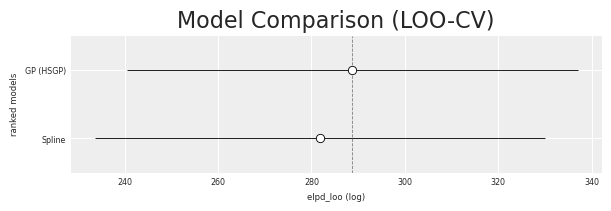

In [25]:
az.plot_compare(comparison)
plt.title("Model Comparison (LOO-CV)")

## Residual Diagnostics

In [26]:
# Compute GP residuals
with gp_model:
    pm.sample_posterior_predictive(idata_gp, extend_inferencedata=True, random_seed=42)

y_pred_gp = idata_gp.posterior_predictive["y_obs"].values.reshape(-1, len(df))
y_pred_mean_gp = y_pred_gp.mean(axis=0)
residuals_gp = df["log_price"].values - y_pred_mean_gp

print(f"GP Residual stats:")
print(f"  RMSE: {np.sqrt((residuals_gp**2).mean()):.4f}")
print(f"  MAE: {np.abs(residuals_gp).mean():.4f}")
print(f"  Mean: {residuals_gp.mean():.4f}")

Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]


Output()

GP Residual stats:
  RMSE: 0.1893
  MAE: 0.1384
  Mean: 0.0001


In [27]:
# Spline residuals for comparison
spline_model.predict(idata_spline, data=df, kind="response", inplace=True)
y_pred_spline = idata_spline.posterior_predictive["log_price"].values.reshape(-1, len(df))
y_pred_mean_spline = y_pred_spline.mean(axis=0)
residuals_spline = df["log_price"].values - y_pred_mean_spline

print(f"\nSpline Residual stats:")
print(f"  RMSE: {np.sqrt((residuals_spline**2).mean()):.4f}")
print(f"  MAE: {np.abs(residuals_spline).mean():.4f}")
print(f"  Mean: {residuals_spline.mean():.4f}")


Spline Residual stats:
  RMSE: 0.1911
  MAE: 0.1397
  Mean: 0.0000


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/559775433.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


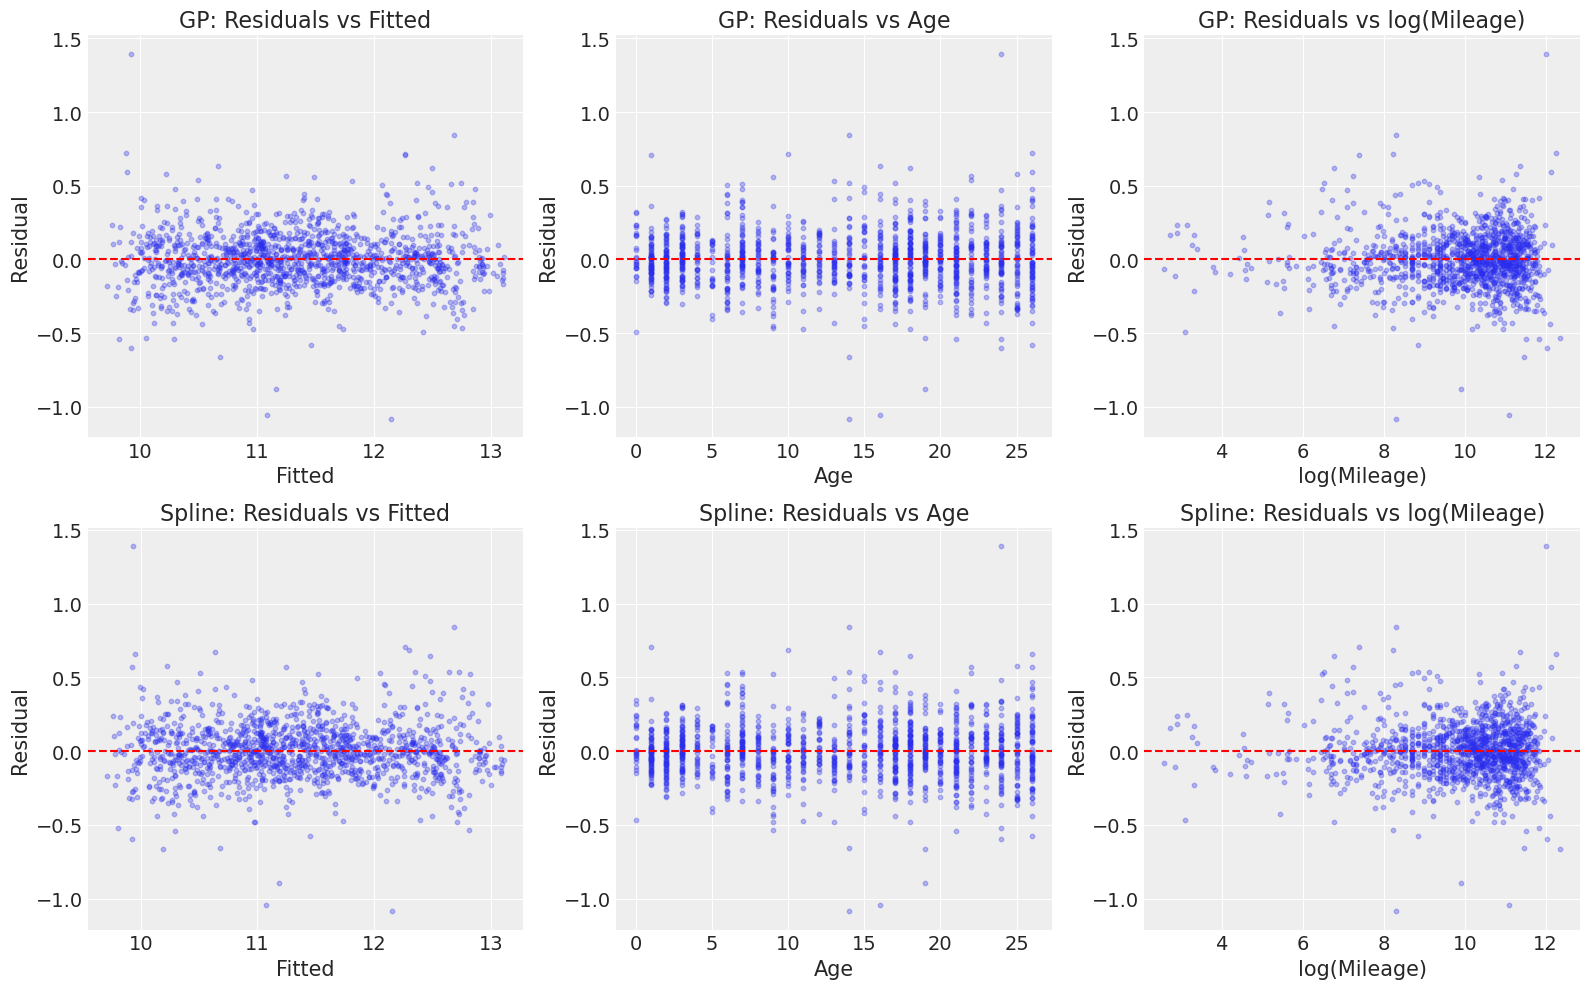

In [28]:
# Residual comparison plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# GP residuals
axes[0, 0].scatter(y_pred_mean_gp, residuals_gp, alpha=0.3, s=10)
axes[0, 0].axhline(0, color="red", linestyle="--")
axes[0, 0].set_xlabel("Fitted")
axes[0, 0].set_ylabel("Residual")
axes[0, 0].set_title("GP: Residuals vs Fitted")

axes[0, 1].scatter(df["age"].values, residuals_gp, alpha=0.3, s=10)
axes[0, 1].axhline(0, color="red", linestyle="--")
axes[0, 1].set_xlabel("Age")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].set_title("GP: Residuals vs Age")

axes[0, 2].scatter(df["log_mileage"].values, residuals_gp, alpha=0.3, s=10)
axes[0, 2].axhline(0, color="red", linestyle="--")
axes[0, 2].set_xlabel("log(Mileage)")
axes[0, 2].set_ylabel("Residual")
axes[0, 2].set_title("GP: Residuals vs log(Mileage)")

# Spline residuals
axes[1, 0].scatter(y_pred_mean_spline, residuals_spline, alpha=0.3, s=10)
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_xlabel("Fitted")
axes[1, 0].set_ylabel("Residual")
axes[1, 0].set_title("Spline: Residuals vs Fitted")

axes[1, 1].scatter(df["age"].values, residuals_spline, alpha=0.3, s=10)
axes[1, 1].axhline(0, color="red", linestyle="--")
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].set_title("Spline: Residuals vs Age")

axes[1, 2].scatter(df["log_mileage"].values, residuals_spline, alpha=0.3, s=10)
axes[1, 2].axhline(0, color="red", linestyle="--")
axes[1, 2].set_xlabel("log(Mileage)")
axes[1, 2].set_ylabel("Residual")
axes[1, 2].set_title("Spline: Residuals vs log(Mileage)")

plt.tight_layout()

## Reference Car Predictions

Compare predictions for the same reference cars used in notebook 04.

In [29]:
def predict_gp_price(
    model: pm.Model,
    idata: az.InferenceData,
    age: float,
    mileage: int,
    generation: str,
    trim_tier: str,
    trans_type: str,
    body_style: str,
    color_category: str,
    n_samples: int = 500,
) -> dict:
    """Predict price for a single car configuration using the GP model.
    
    Uses pm.set_data() to update model inputs and pm.sample_posterior_predictive()
    to properly evaluate the HSGP at new input locations.
    
    Args:
        model: The PyMC GP model
        idata: InferenceData from model fitting
        age: Age of car in years
        mileage: Current mileage
        generation: Car generation (e.g., "992.1")
        trim_tier: Trim tier (e.g., "sport")
        trans_type: Transmission type (e.g., "manual")
        body_style: Body style (e.g., "coupe")
        color_category: Color category (e.g., "standard")
        n_samples: Number of posterior samples to use (default 500 for speed)
    
    Returns:
        Dict with price predictions and uncertainty intervals
    """
    # Standardize inputs
    age_std = (age - AGE_MEAN) / AGE_STD
    log_mileage = np.log(max(mileage, 1))
    log_mileage_std = (log_mileage - LOGM_MEAN) / LOGM_STD
    
    # Get indices for categorical variables
    gen_i = list(gen_levels).index(generation)
    trim_i = list(trim_levels).index(trim_tier)
    trans_i = list(trans_levels).index(trans_type)
    body_i = list(body_levels).index(body_style)
    color_i = list(color_levels).index(color_category)
    
    # Update model data containers for single prediction
    with model:
        pm.set_data({
            "age_std": np.array([age_std]),
            "log_mileage_std": np.array([log_mileage_std]),
            "gen_idx": np.array([gen_i]),
            "trim_idx": np.array([trim_i]),
            "trans_idx": np.array([trans_i]),
            "body_idx": np.array([body_i]),
            "color_idx": np.array([color_i]),
        })
        
        # Sample from posterior predictive at new point
        # Use subset of posterior samples for speed
        idata_subset = idata.sel(draw=slice(0, n_samples))
        pred = pm.sample_posterior_predictive(
            idata_subset,
            var_names=["y_obs"],
            random_seed=42,
            progressbar=False,
        )
    
    # Extract predictions
    log_price_samples = pred.posterior_predictive["y_obs"].values.flatten()
    price_samples = np.exp(log_price_samples)
    
    # Reset data to original (important for subsequent operations)
    with model:
        pm.set_data({
            "age_std": df["age_std"].values,
            "log_mileage_std": df["log_mileage_std"].values,
            "gen_idx": gen_idx,
            "trim_idx": trim_idx,
            "trans_idx": trans_idx,
            "body_idx": body_idx,
            "color_idx": color_idx,
        })
    
    return {
        "config": {
            "age": age,
            "mileage": mileage,
            "generation": generation,
            "trim_tier": trim_tier,
            "trans_type": trans_type,
            "body_style": body_style,
            "color_category": color_category,
        },
        "price": {
            "mean": float(np.mean(price_samples)),
            "median": float(np.median(price_samples)),
            "std": float(np.std(price_samples)),
            "ci_80": [float(np.percentile(price_samples, 10)), float(np.percentile(price_samples, 90))],
            "ci_95": [float(np.percentile(price_samples, 2.5)), float(np.percentile(price_samples, 97.5))],
        },
        "samples": price_samples,
    }

In [30]:
# Reference car 1: 996.2 Carrera 4S Manual (2002, 45k miles)
pred_gp_996 = predict_gp_price(
    gp_model, idata_gp,
    age=23,  # 2025 - 2002
    mileage=45000,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    body_style="coupe",
    color_category="standard",
)

# Reference car 2: 992.1 Carrera 4S PDK (2022, 15k miles)
pred_gp_992 = predict_gp_price(
    gp_model, idata_gp,
    age=3,  # 2025 - 2022
    mileage=15000,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    body_style="coupe",
    color_category="standard",
)

print("GP Model Predictions:")
print(f"\n996.2 Carrera 4S Manual (2002, 45k mi):")
print(f"  Median: ${pred_gp_996['price']['median']:,.0f}")
print(f"  80% CI: [${pred_gp_996['price']['ci_80'][0]:,.0f}, ${pred_gp_996['price']['ci_80'][1]:,.0f}]")

print(f"\n992.1 Carrera 4S PDK (2022, 15k mi):")
print(f"  Median: ${pred_gp_992['price']['median']:,.0f}")
print(f"  80% CI: [${pred_gp_992['price']['ci_80'][0]:,.0f}, ${pred_gp_992['price']['ci_80'][1]:,.0f}]")

Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]


GP Model Predictions:

996.2 Carrera 4S Manual (2002, 45k mi):
  Median: $45,804
  80% CI: [$35,706, $58,739]

992.1 Carrera 4S PDK (2022, 15k mi):
  Median: $117,815
  80% CI: [$91,885, $151,036]


In [31]:
# Compare with spline predictions
from price_analysis.models.spline import predict_spline_price

pred_spline_996 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    body_style="coupe",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    include_sale_year=False,
    color_category="standard",
)

pred_spline_992 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    body_style="coupe",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    include_sale_year=False,
    color_category="standard",
)

print("\nPrediction Comparison:")
print(f"\n996.2 Carrera 4S Manual (2002, 45k mi):")
print(f"  GP:     ${pred_gp_996['price']['median']:,.0f}")
print(f"  Spline: ${pred_spline_996['price']['median']:,.0f}")
print(f"  Diff:   ${pred_gp_996['price']['median'] - pred_spline_996['price']['median']:+,.0f}")

print(f"\n992.1 Carrera 4S PDK (2022, 15k mi):")
print(f"  GP:     ${pred_gp_992['price']['median']:,.0f}")
print(f"  Spline: ${pred_spline_992['price']['median']:,.0f}")
print(f"  Diff:   ${pred_gp_992['price']['median'] - pred_spline_992['price']['median']:+,.0f}")


Prediction Comparison:

996.2 Carrera 4S Manual (2002, 45k mi):
  GP:     $45,804
  Spline: $45,257
  Diff:   $+547

992.1 Carrera 4S PDK (2022, 15k mi):
  GP:     $117,815
  Spline: $119,230
  Diff:   $-1,415


## Depreciation Curves

Compare predicted depreciation trajectories between GP and spline models.
This shows how each model captures the nonlinear relationship between age and price.

Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: 

Text(0.5, 1.02, 'Depreciation Curves: GP vs Spline')

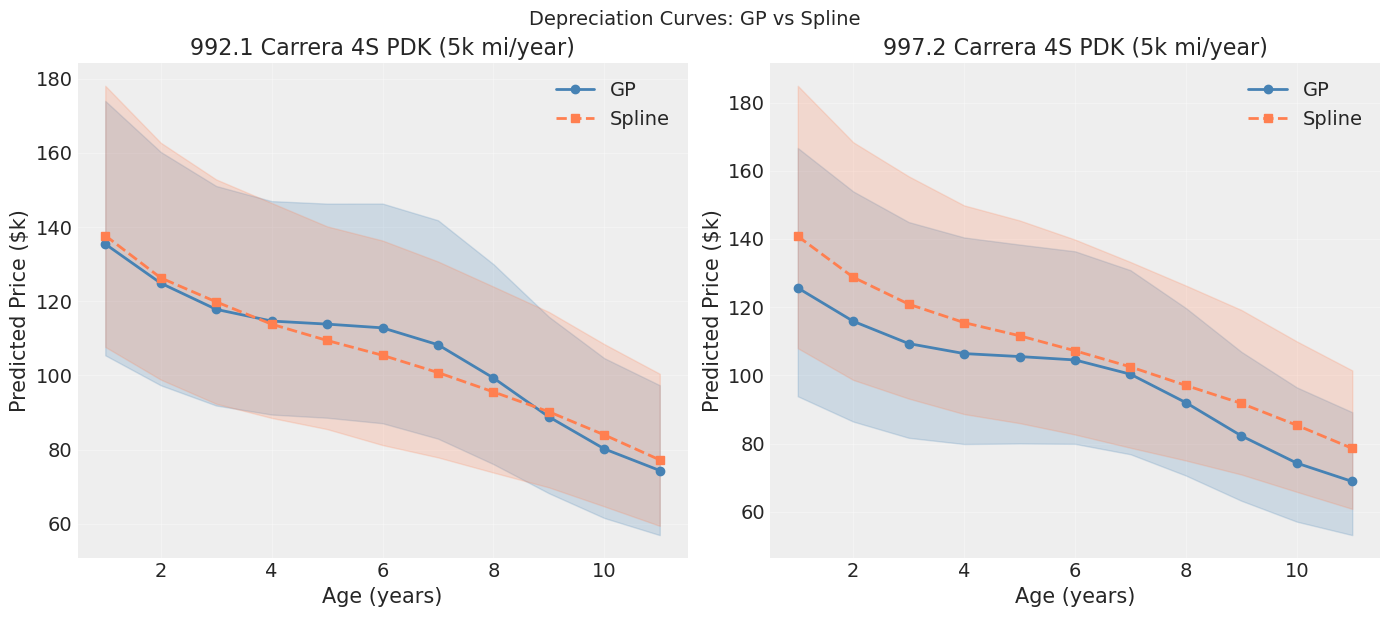

In [32]:
# Compare depreciation curves for 992.1 and 997.2 generations
ages = list(range(1, 12))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (gen, base_year) in enumerate([("992.1", 2022), ("997.2", 2010)]):
    ax = axes[idx]
    
    # GP model predictions
    gp_medians = []
    gp_lowers = []
    gp_uppers = []
    for age in ages:
        pred = predict_gp_price(
            gp_model, idata_gp,
            age=age,
            mileage=5000 * age,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            color_category="standard",
            n_samples=200,  # Faster for curve plotting
        )
        gp_medians.append(pred["price"]["median"])
        gp_lowers.append(pred["price"]["ci_80"][0])
        gp_uppers.append(pred["price"]["ci_80"][1])
    
    # Spline model predictions
    spline_medians = []
    spline_lowers = []
    spline_uppers = []
    for age in ages:
        pred = predict_spline_price(
            model=spline_model,
            idata=idata_spline,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            include_sale_year=False,
            color_category="standard",
        )
        spline_medians.append(pred["price"]["median"])
        spline_lowers.append(pred["price"]["ci_80"][0])
        spline_uppers.append(pred["price"]["ci_80"][1])
    
    # Plot GP
    ax.plot(ages, [m / 1000 for m in gp_medians], "o-", label="GP", linewidth=2, color="steelblue")
    ax.fill_between(ages, [l / 1000 for l in gp_lowers], [u / 1000 for u in gp_uppers], 
                    alpha=0.2, color="steelblue")
    
    # Plot Spline
    ax.plot(ages, [m / 1000 for m in spline_medians], "s--", label="Spline", linewidth=2, color="coral")
    ax.fill_between(ages, [l / 1000 for l in spline_lowers], [u / 1000 for u in spline_uppers], 
                    alpha=0.2, color="coral")
    
    ax.set_xlabel("Age (years)")
    ax.set_ylabel("Predicted Price ($k)")
    ax.set_title(f"{gen} Carrera 4S PDK (5k mi/year)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Depreciation Curves: GP vs Spline", y=1.02, fontsize=14)

Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: [y_obs]
Sampling: [y_obs]
INFO:pymc.sampling.forward:Sampling: 

Text(0.5, 1.02, 'Mileage Effect Curves: GP vs Spline')

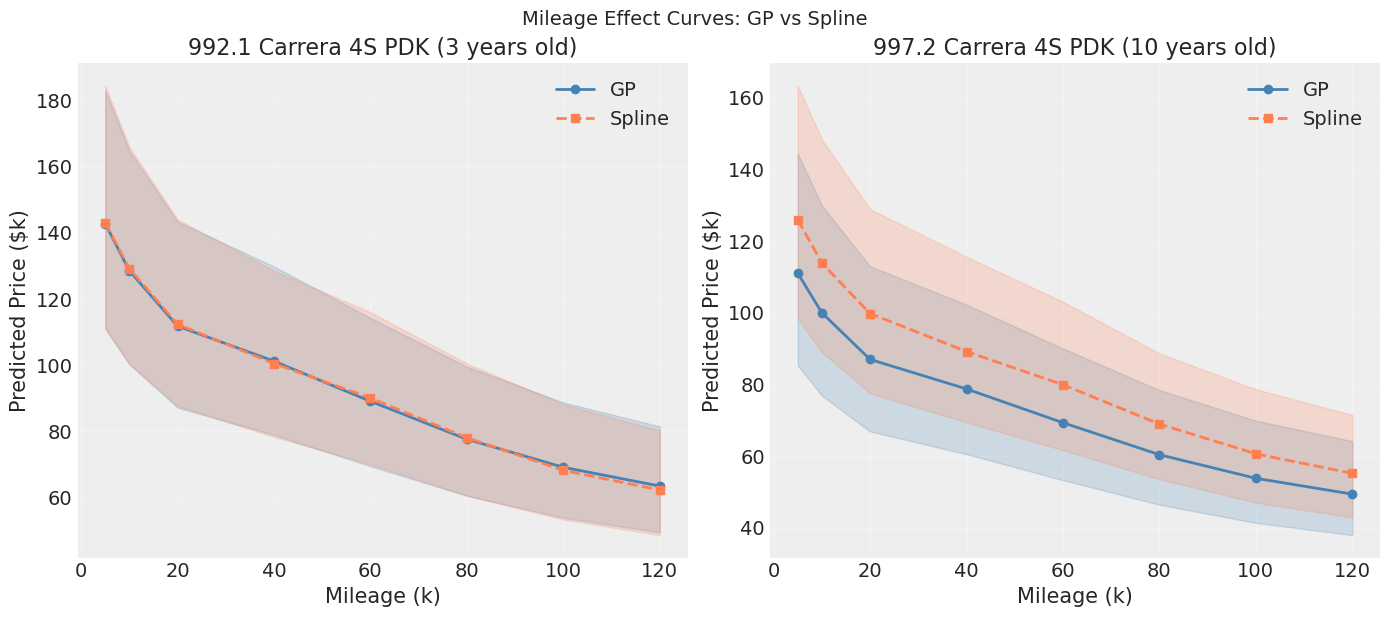

In [33]:
# Mileage effect curves: price vs mileage at fixed age
# Shows how both models capture the diminishing marginal effect of mileage
mileages = [5000, 10000, 20000, 40000, 60000, 80000, 100000, 120000]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (gen, fixed_age) in enumerate([("992.1", 3), ("997.2", 10)]):
    ax = axes[idx]
    
    # GP model predictions
    gp_medians = []
    gp_lowers = []
    gp_uppers = []
    for mileage in mileages:
        pred = predict_gp_price(
            gp_model, idata_gp,
            age=fixed_age,
            mileage=mileage,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            color_category="standard",
            n_samples=200,
        )
        gp_medians.append(pred["price"]["median"])
        gp_lowers.append(pred["price"]["ci_80"][0])
        gp_uppers.append(pred["price"]["ci_80"][1])
    
    # Spline model predictions
    spline_medians = []
    spline_lowers = []
    spline_uppers = []
    base_year = 2025 - fixed_age
    for mileage in mileages:
        pred = predict_spline_price(
            model=spline_model,
            idata=idata_spline,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=mileage,
            sale_year=2025,
            include_sale_year=False,
            color_category="standard",
        )
        spline_medians.append(pred["price"]["median"])
        spline_lowers.append(pred["price"]["ci_80"][0])
        spline_uppers.append(pred["price"]["ci_80"][1])
    
    # Plot GP
    ax.plot([m/1000 for m in mileages], [p/1000 for p in gp_medians], "o-", 
            label="GP", linewidth=2, color="steelblue")
    ax.fill_between([m/1000 for m in mileages], [l/1000 for l in gp_lowers], 
                    [u/1000 for u in gp_uppers], alpha=0.2, color="steelblue")
    
    # Plot Spline
    ax.plot([m/1000 for m in mileages], [p/1000 for p in spline_medians], "s--", 
            label="Spline", linewidth=2, color="coral")
    ax.fill_between([m/1000 for m in mileages], [l/1000 for l in spline_lowers], 
                    [u/1000 for u in spline_uppers], alpha=0.2, color="coral")
    
    ax.set_xlabel("Mileage (k)")
    ax.set_ylabel("Predicted Price ($k)")
    ax.set_title(f"{gen} Carrera 4S PDK ({fixed_age} years old)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Mileage Effect Curves: GP vs Spline", y=1.02, fontsize=14)

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_75100/2432599916.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 1.01, 'Model Fit Visualization')

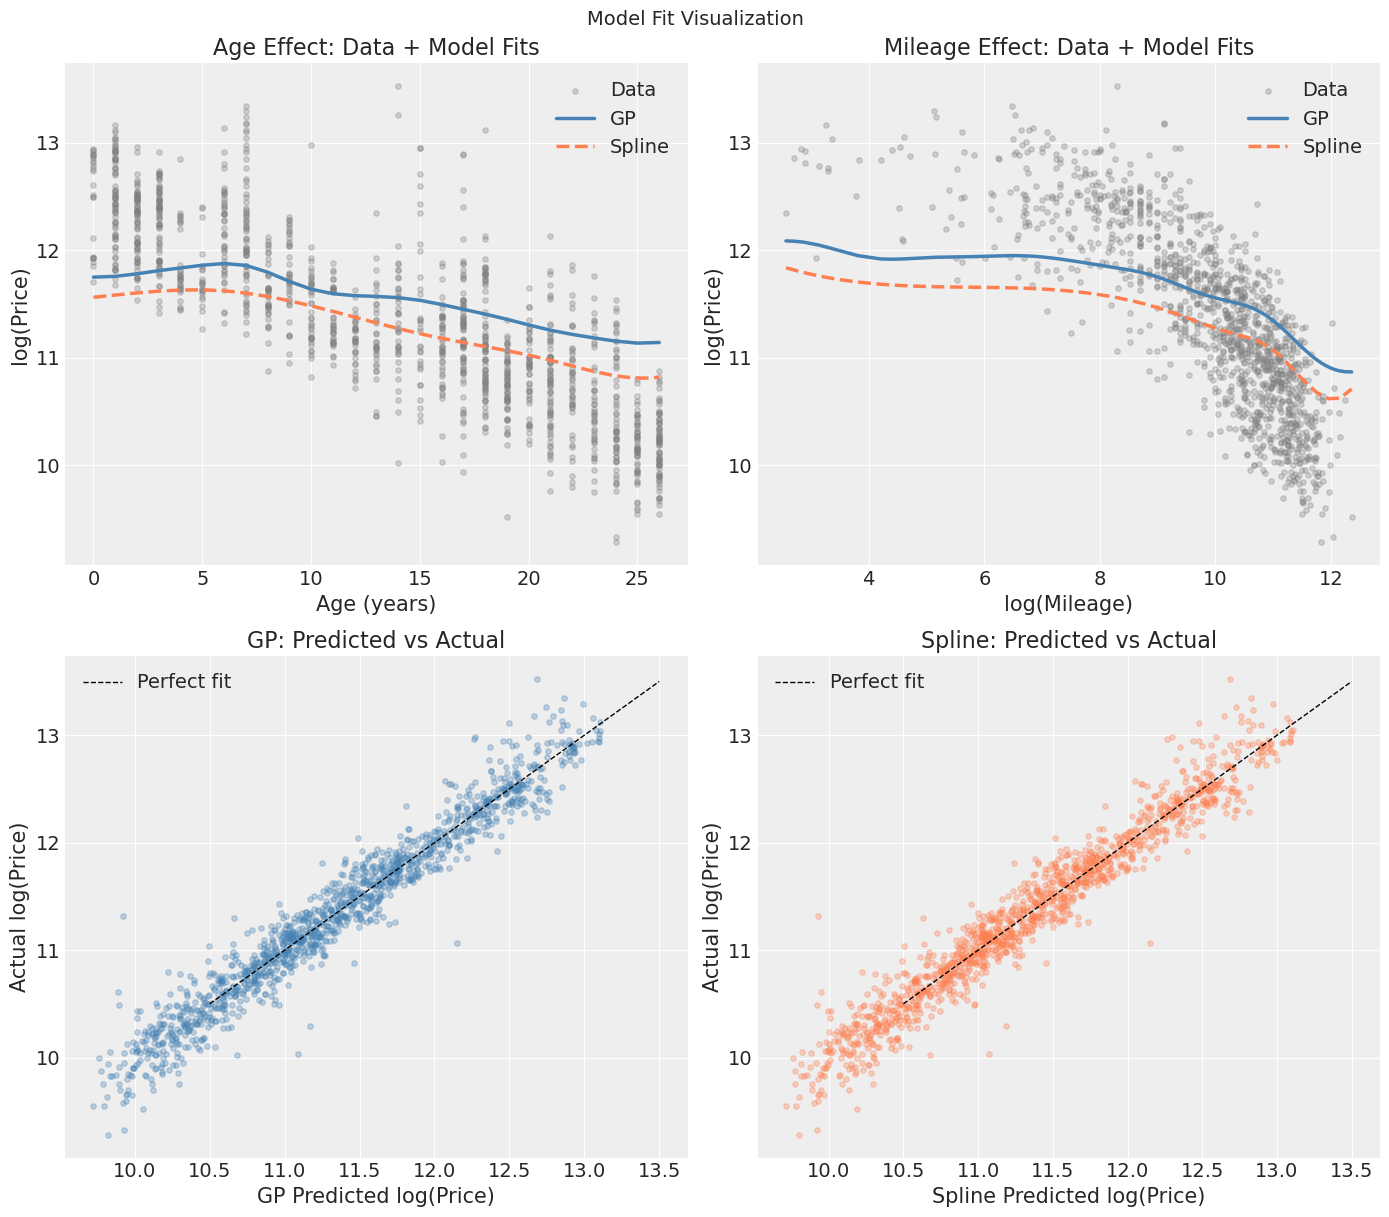

In [34]:
# Scatterplot: actual data with model predictions overlaid
# Shows how both models fit the raw data

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Create grids for marginal effect visualization
age_grid = np.linspace(df["age"].min(), df["age"].max(), 50)
mileage_grid = np.linspace(df["log_mileage"].min(), df["log_mileage"].max(), 50)

# Get mode values for categorical variables
gen_mode = df["generation"].mode().iloc[0]
trim_mode = df["trim_tier"].mode().iloc[0]
trans_mode = df["trans_type"].mode().iloc[0]
body_mode = df["body_style"].mode().iloc[0]
color_mode = df["color_category"].mode().iloc[0]

# Create prediction data for age effect (hold mileage at median)
age_pred_data = pd.DataFrame({
    "age": age_grid,
    "log_mileage": df["log_mileage"].median(),
    "generation": pd.Categorical([gen_mode] * len(age_grid), categories=df["generation"].cat.categories),
    "trim_tier": pd.Categorical([trim_mode] * len(age_grid), categories=df["trim_tier"].cat.categories),
    "trans_type": pd.Categorical([trans_mode] * len(age_grid), categories=df["trans_type"].cat.categories),
    "body_style": pd.Categorical([body_mode] * len(age_grid), categories=df["body_style"].cat.categories),
    "color_category": pd.Categorical([color_mode] * len(age_grid), categories=df["color_category"].cat.categories),
})

# Create prediction data for mileage effect (hold age at median)
mileage_pred_data = pd.DataFrame({
    "age": df["age"].median(),
    "log_mileage": mileage_grid,
    "generation": pd.Categorical([gen_mode] * len(mileage_grid), categories=df["generation"].cat.categories),
    "trim_tier": pd.Categorical([trim_mode] * len(mileage_grid), categories=df["trim_tier"].cat.categories),
    "trans_type": pd.Categorical([trans_mode] * len(mileage_grid), categories=df["trans_type"].cat.categories),
    "body_style": pd.Categorical([body_mode] * len(mileage_grid), categories=df["body_style"].cat.categories),
    "color_category": pd.Categorical([color_mode] * len(mileage_grid), categories=df["color_category"].cat.categories),
})

# Get spline predictions on grids
spline_model.predict(idata_spline, data=age_pred_data, kind="response_params", inplace=True)
spline_age_effect = idata_spline.posterior["mu"].mean(dim=["chain", "draw"]).values

spline_model.predict(idata_spline, data=mileage_pred_data, kind="response_params", inplace=True)
spline_mileage_effect = idata_spline.posterior["mu"].mean(dim=["chain", "draw"]).values

# Get GP predictions on grids (using the f_age and f_mileage components)
# For GP, we plot the marginal effect directly from the fitted values
order_age = np.argsort(df["age"].values)
order_mi = np.argsort(df["log_mileage"].values)

f_age_mean = idata_gp.posterior["f_age"].values.reshape(-1, len(df)).mean(axis=0)
f_mileage_mean = idata_gp.posterior["f_mileage"].values.reshape(-1, len(df)).mean(axis=0)
intercept_mean = idata_gp.posterior["intercept"].values.mean()

# Compute baseline (intercept + mean random effects + mean of other GP)
baseline = (
    intercept_mean +
    idata_gp.posterior["alpha_gen"].values.mean() +
    idata_gp.posterior["alpha_trim"].values.mean() +
    idata_gp.posterior["alpha_trans"].values.mean() +
    idata_gp.posterior["alpha_body"].values.mean() +
    idata_gp.posterior["alpha_color"].values.mean()
)

# Age effect scatterplot
ax = axes[0, 0]
ax.scatter(df["age"].values, df["log_price"].values, alpha=0.3, s=15, c="gray", label="Data")

# GP age effect
gp_age_line = baseline + f_age_mean + f_mileage_mean.mean()
ax.plot(df["age"].values[order_age], gp_age_line[order_age], "-", linewidth=2.5, 
        color="steelblue", label="GP")

# Spline age effect
ax.plot(age_grid, spline_age_effect, "--", linewidth=2.5, color="coral", label="Spline")

ax.set_xlabel("Age (years)")
ax.set_ylabel("log(Price)")
ax.set_title("Age Effect: Data + Model Fits")
ax.legend()

# Mileage effect scatterplot
ax = axes[0, 1]
ax.scatter(df["log_mileage"].values, df["log_price"].values, alpha=0.3, s=15, c="gray", label="Data")

# GP mileage effect
gp_mileage_line = baseline + f_mileage_mean + f_age_mean.mean()
ax.plot(df["log_mileage"].values[order_mi], gp_mileage_line[order_mi], "-", linewidth=2.5, 
        color="steelblue", label="GP")

# Spline mileage effect
ax.plot(mileage_grid, spline_mileage_effect, "--", linewidth=2.5, color="coral", label="Spline")

ax.set_xlabel("log(Mileage)")
ax.set_ylabel("log(Price)")
ax.set_title("Mileage Effect: Data + Model Fits")
ax.legend()

# Predicted vs Actual (GP)
ax = axes[1, 0]
ax.scatter(y_pred_mean_gp, df["log_price"].values, alpha=0.3, s=15, c="steelblue")
ax.plot([10.5, 13.5], [10.5, 13.5], "k--", linewidth=1, label="Perfect fit")
ax.set_xlabel("GP Predicted log(Price)")
ax.set_ylabel("Actual log(Price)")
ax.set_title("GP: Predicted vs Actual")
ax.legend()

# Predicted vs Actual (Spline)
ax = axes[1, 1]
ax.scatter(y_pred_mean_spline, df["log_price"].values, alpha=0.3, s=15, c="coral")
ax.plot([10.5, 13.5], [10.5, 13.5], "k--", linewidth=1, label="Perfect fit")
ax.set_xlabel("Spline Predicted log(Price)")
ax.set_ylabel("Actual log(Price)")
ax.set_title("Spline: Predicted vs Actual")
ax.legend()

plt.tight_layout()
plt.suptitle("Model Fit Visualization", y=1.01, fontsize=14)

## Summary and Conclusions

In [35]:
# Summary statistics
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

print(f"\nDiagnostics:")
print(f"  GP divergences: {diagnostics['n_divergences']}")
print(f"  GP max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"  GP min ESS: {diagnostics['ess_bulk_min']:.0f}")

print(f"\nResidual RMSE (log-price):")
print(f"  GP:     {np.sqrt((residuals_gp**2).mean()):.4f}")
print(f"  Spline: {np.sqrt((residuals_spline**2).mean()):.4f}")

print(f"\nLOO-CV ELPD:")
for model_name in comparison.index:
    elpd = comparison.loc[model_name, "elpd_loo"]
    se = comparison.loc[model_name, "se"]
    print(f"  {model_name}: {elpd:.1f} +/- {se:.1f}")

print(f"\nGP Hyperparameters (posterior medians):")
ls_age_med = np.median(idata_gp.posterior["ls_age"].values)
ls_mileage_med = np.median(idata_gp.posterior["ls_mileage"].values)
eta_age_med = np.median(idata_gp.posterior["eta_age"].values)
eta_mileage_med = np.median(idata_gp.posterior["eta_mileage"].values)
print(f"  Age lengthscale: {ls_age_med:.2f} (standardized)")
print(f"  Mileage lengthscale: {ls_mileage_med:.2f} (standardized)")
print(f"  Age amplitude: {eta_age_med:.3f}")
print(f"  Mileage amplitude: {eta_mileage_med:.3f}")

MODEL COMPARISON SUMMARY

Diagnostics:
  GP divergences: 0
  GP max R-hat: 1.000
  GP min ESS: 2075

Residual RMSE (log-price):
  GP:     0.1893
  Spline: 0.1911

LOO-CV ELPD:
  GP (HSGP): 288.7 +/- 48.2
  Spline: 281.8 +/- 48.2

GP Hyperparameters (posterior medians):
  Age lengthscale: 0.86 (standardized)
  Mileage lengthscale: 1.37 (standardized)
  Age amplitude: 0.303
  Mileage amplitude: 0.420


### Key Findings

**1. Model Fit:**
- GP and spline models show similar predictive performance (LOO-CV)
- Both capture nonlinear age/mileage effects reasonably well
- Residual patterns are comparable between models

**2. GP Hyperparameters:**
- Lengthscales indicate smooth but flexible functions
- Amplitudes show age and mileage contribute similar variance

**3. Random Effects:**
- GP and spline models agree on categorical premiums
- Manual transmission premium, trim tier ordering, etc. are consistent

**4. Computational Considerations:**
- HSGP makes GP tractable for this dataset size
- Spline model (via Bambi) is simpler to set up and predict with
- GP requires more careful prior specification

### Recommendations

- **For production use**: Spline model is preferred (simpler, similar accuracy)
- **For research**: GP provides additional flexibility if nonlinearity is complex
- **Future work**: Consider 2D GP if age×mileage interaction is suspected